In [27]:
import pandas as pd
import numpy as np

LOAD FILE AND GET THE CORRECT DATAFRAME

In [3]:
df = pd.read_csv('igeni.csv')

In [4]:
df_volumn = df[df['Unidad de medida'] == 'Índice de volumen físico base 2013=100'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()
df_acc_volumn = df[df['Unidad de medida'] == 'Índice de volumen físico acumulado base 2013=100'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()
df_percent = df[df['Unidad de medida'] == 'Variación porcentual del índice de volumen físico'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()
df_acc_percent = df[df['Unidad de medida'] == 'Variación porcentual del índice de volumen físico acumulado'][['Periodo', 'Valor']].sort_values(by=['Periodo']).reset_index().copy()

In [38]:
df_volumn.head()

,index,Periodo,Valor
0,1340,1993/01,48.100864
1,1339,1993/02,48.733164
2,1338,1993/03,46.038430
3,1337,1993/04,48.742361
4,1336,1993/05,50.833388


<AxesSubplot: xlabel='Periodo'>

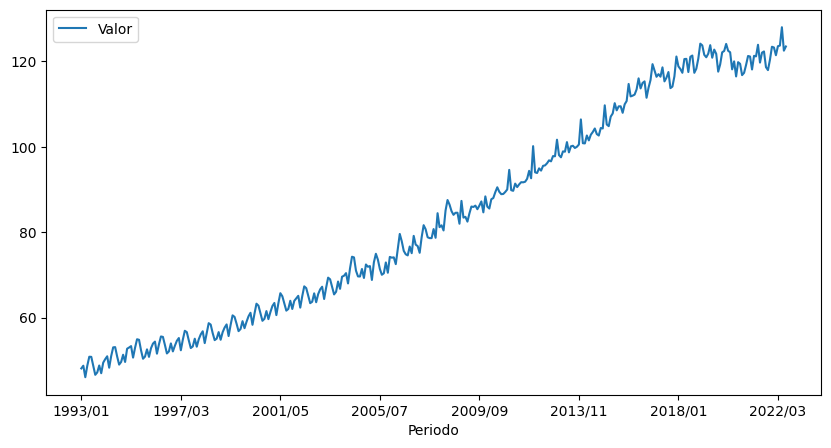

In [44]:
df_volumn.plot('Periodo', 'Valor', kind ='line', figsize=(10,5))

THE VALOR LOOKS WITH A CLEAN INCREASE TREND, SO IT IS NOT STATIONARY.
AND IT HAS A SEASONAL PATTERN

# Perform statistical tests of stationarity and decide the type of transformation of the variable

WE USE THE SEASONAL DIFFERENCE OF THE LOG OF SERIES, CHECK MONTHLY, QUARTERLY AND ANNUAL DIFFERENCE

In [6]:
df = df_volumn.copy()
df['diff_monthly'] = np.log(df['Valor']) - np.log(df['Valor'].shift(1))
df['diff_quater'] = np.log(df['Valor']) - np.log(df['Valor'].shift(3))
df['diff_annual'] = np.log(df['Valor']) - np.log(df['Valor'].shift(12))

<AxesSubplot: xlabel='Periodo'>

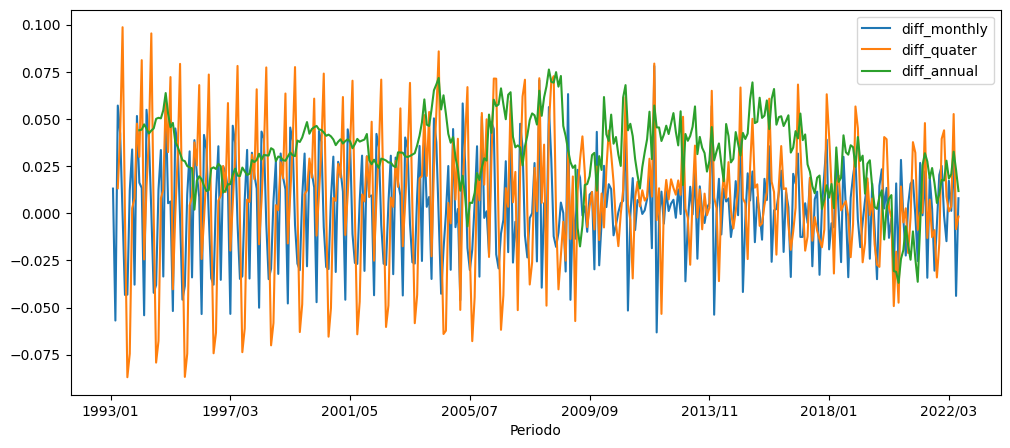

In [46]:
df.plot('Periodo', ['diff_monthly', 'diff_quater', 'diff_annual'], kind = 'line', figsize=(12,5))

In [36]:
#df.head(24)

In [30]:
list_diff_quarter = df['diff_quater'].dropna().tolist()
list_diff_monthly = df['diff_monthly'].dropna().tolist()
list_diff_annual = df['diff_annual'].dropna().tolist()

In [8]:
from statsmodels.tsa.stattools import adfuller

USE DICKY FULLER TER TO CHECK THE STATIONARY OF THE SEASON DATA, TO CHECK THE SEASONALITY

In [35]:
#adfuller(df['Valor'].tolist())

In [32]:
adfuller(list_diff_monthly)

(-3.6440485223843444,
 0.004972651961633321,
 13,
 340,
 {'1%': -3.4497304638968043,
  '5%': -2.8700785273763487,
  '10%': -2.571319005190311},
 -2132.7923974274536)

In [33]:
adfuller(list_diff_quarter)

(-3.692815564239722,
 0.00421535207618755,
 11,
 340,
 {'1%': -3.4497304638968043,
  '5%': -2.8700785273763487,
  '10%': -2.571319005190311},
 -2116.756442184382)

In [34]:
adfuller(list_diff_annual)

(-3.4476057501271464,
 0.009439170431343487,
 12,
 330,
 {'1%': -3.4503224123605194,
  '5%': -2.870338478726661,
  '10%': -2.571457612488522},
 -2082.2581392100105)

P VALUE OF THE ORIGINAL VALUE IS 0.96, MUCH MORE THAN 0.05, SO THE ORIGINAL VALUE IS NON-STATIONARY.

P VALUE OF THE DIFF_MONTHLY, DIFF_QUATER, DIFF_ANNUAL ARE ALL LESS THAN 0.05, SO THEY ARE ALL STATIONARY.

WE WILL CONTINUE TO CHECK TO CALIBRATE AN ARIMA-SARIMA MODEL

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

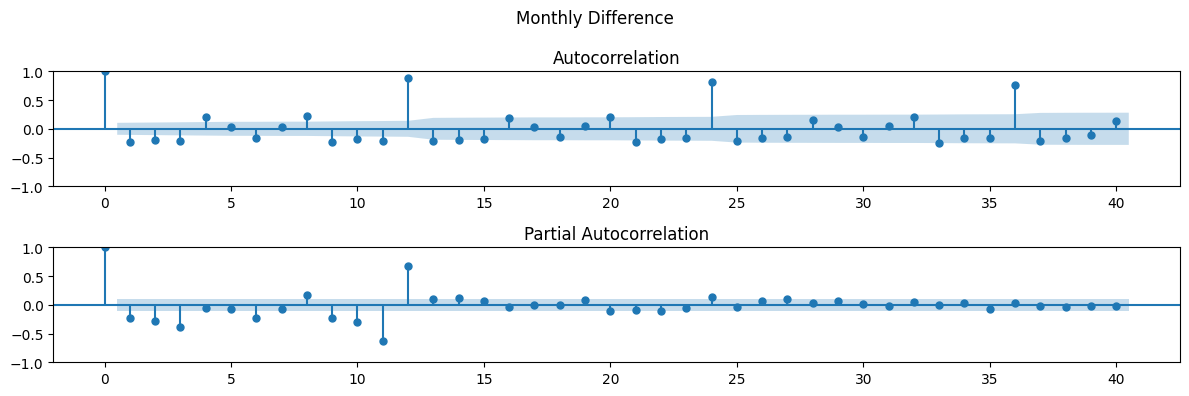

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(12,4))
plot_acf(list_diff_monthly, lags = 40, ax = axs[0])
plot_pacf(list_diff_monthly, lags = 40, method='ywm', ax = axs[1])
fig.suptitle('Monthly Difference')
fig.tight_layout()
plt.show()


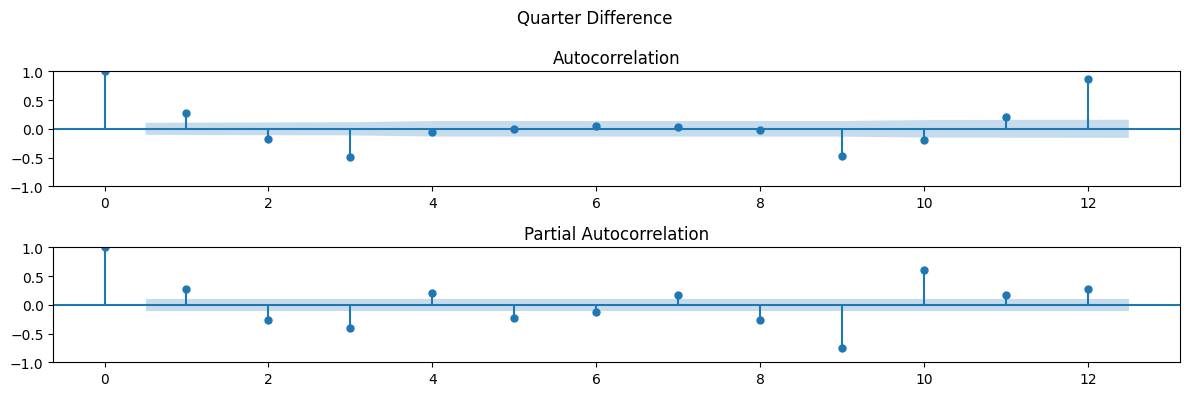

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(12,4))
plot_acf(list_diff_quarter, lags = 12, ax = axs[0])
plot_pacf(list_diff_quarter, lags = 12, method='ywm', ax = axs[1])
fig.suptitle('Quarter Difference')
fig.tight_layout()
plt.show()

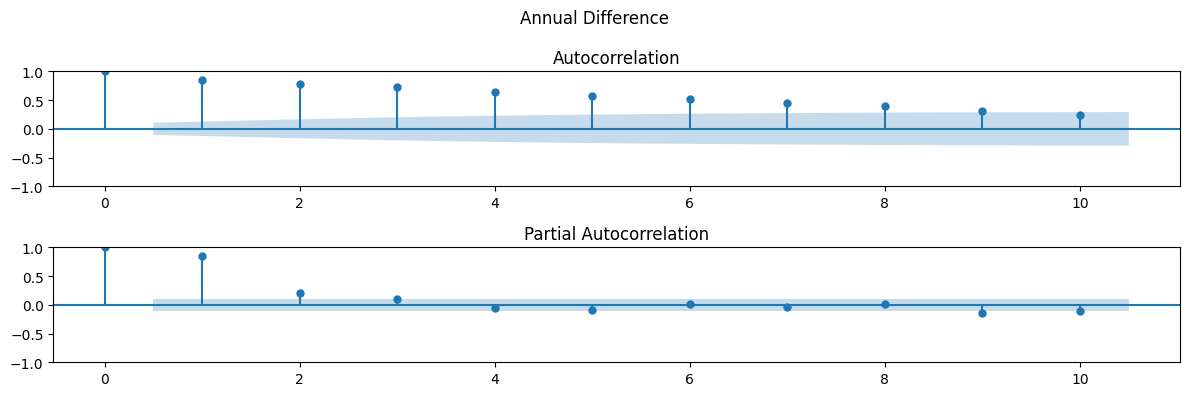

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(12,4))
plot_acf(list_diff_annual, lags = 10, ax = axs[0])
plot_pacf(list_diff_annual, lags = 10, method='ywm', ax = axs[1])
fig.suptitle('Annual Difference')
fig.tight_layout()
plt.show()

In [29]:
ar_model = AutoReg(df['diff_monthly'].dropna().tolist(), lags = 24).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  354
Model:                    AutoReg(24)   Log Likelihood                1084.754
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Thu, 03 Nov 2022   AIC                          -2117.509
Time:                        16:16:32   BIC                          -2018.732
Sample:                            24   HQIC                         -2078.108
                                  354                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.097      0.002       0.001       0.006
y.L1          -0.3639      0.053     -6.898      0.000      -0.467      -0.261
y.L2          -0.1872      0.056     -3.332      0.001      -0.297      -0.077
y.L3          -0.0125      0.057     -0.219      0.827      -0.124       0.099
y.L4           0.0139      0.056      0.247      0.805      -0.096       0.124
y.L5          -0.1161      0.056     -2.087      0.037      -0.225      -0.007
y.L6          -0.0880      0.056     -1.571      0.116      -0.198       0.022
y.L7          -0.1053      0.056     -1.874      0.061      -0.215       0.005
y.L8           0.0617      0.057      1.092      0.275      -0.049       0.173
y.L9           0.0084      0.056      0.150      0.881      -0.102       0.119
y.L10         -0.0604      0.056     -1.078      0.281      -0.170       0.049
y.L11         -0.2064      0.056     -3.670      0.000      -0.317      -0.096
y.L12          0.4943      0.056      8.824      0.000       0.384       0.604
y.L13          0.2072      0.054      3.808      0.000       0.101       0.314
y.L14          0.0608      0.055      1.113      0.266      -0.046       0.168
y.L15         -0.0892      0.055     -1.632      0.103      -0.196       0.018
y.L16         -0.1202      0.055     -2.189      0.029      -0.228      -0.013
y.L17          0.0301      0.055      0.545      0.586      -0.078       0.138
y.L18         -0.0240      0.055     -0.436      0.663      -0.132       0.084
y.L19          0.0035      0.055      0.063      0.950      -0.104       0.111
y.L20         -0.1569      0.054     -2.883      0.004      -0.264      -0.050
y.L21         -0.1493      0.055     -2.708      0.007      -0.257      -0.041
y.L22         -0.0694      0.056     -1.247      0.213      -0.178       0.040
y.L23          0.0786      0.055      1.430      0.153      -0.029       0.186
y.L24          0.2887      0.052      5.576      0.000       0.187       0.390
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.8677           -0.5044j            1.0036           -0.4162
AR.2            -0.8677           +0.5044j            1.0036            0.4162
AR.3            -1.0075           -0.0000j            1.0075           -0.5000
AR.4            -1.0835           -0.2391j            1.1096           -0.4654
AR.5            -1.0835           +0.2391j            1.1096            0.4654
AR.6            -0.7791           -0.7698j            1.0952           -0.3760
AR.7            -0.7791           +0.7698j            1.0952            0.3760
AR.8            -0.5086           -0.8726j            1.0100           -0.3340
AR.9            -0.5086           +0.8726j            1.0100            0.3340
AR

# Calibrates an ARIMA-SARIMA model based on autocorrelation tests and plots. It clearly explains the calibration process and the reason for how it changes the parameters.

# Interpret the coefficients and their statistical significance of the calibrated model

# It makes a prediction of the variable using the calibrated model.